# **Assignment 4: Implementation of cost sesitive logisitic regression.** 

## Submitted by:

1. Nitish Kumar Gundapu **AI22MTECH14004** \\
2. Soumyanetra Pal **AI22MTECH14005** \\
3. Major Raviraj Deshmukh **AI22MTECH13008** \\
4. Vishnu Vijay Tiwari **AI22MTECH14003**

Installing PYGAD Package for Genetic Algorithm

In [ ]:
#Installing necessary packages
!pip3 install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##0.Importing necessary packages

In [ ]:
import torch as t
import torch.nn as nn
import pygad
from pygad import torchga
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split as tts
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Data

### 1.1 Fetching Data from dataset

In [ ]:
data = pd.read_csv("costsensitiveregression.csv")
data.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


### 1.2 Data description

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147636 entries, 0 to 147635
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   NotCount  147636 non-null  int64  
 1   YesCount  147636 non-null  int64  
 2   ATPM      147636 non-null  float64
 3   PFD       147636 non-null  float64
 4   PFG       147636 non-null  float64
 5   SFD       147636 non-null  float64
 6   SFG       147636 non-null  float64
 7   WP        147636 non-null  float64
 8   WS        147636 non-null  float64
 9   AH        147636 non-null  float64
 10  AN        147636 non-null  float64
 11  Status    147636 non-null  int64  
 12  FNC       147636 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 14.6 MB


### 1.3 Pearson Corelation of data

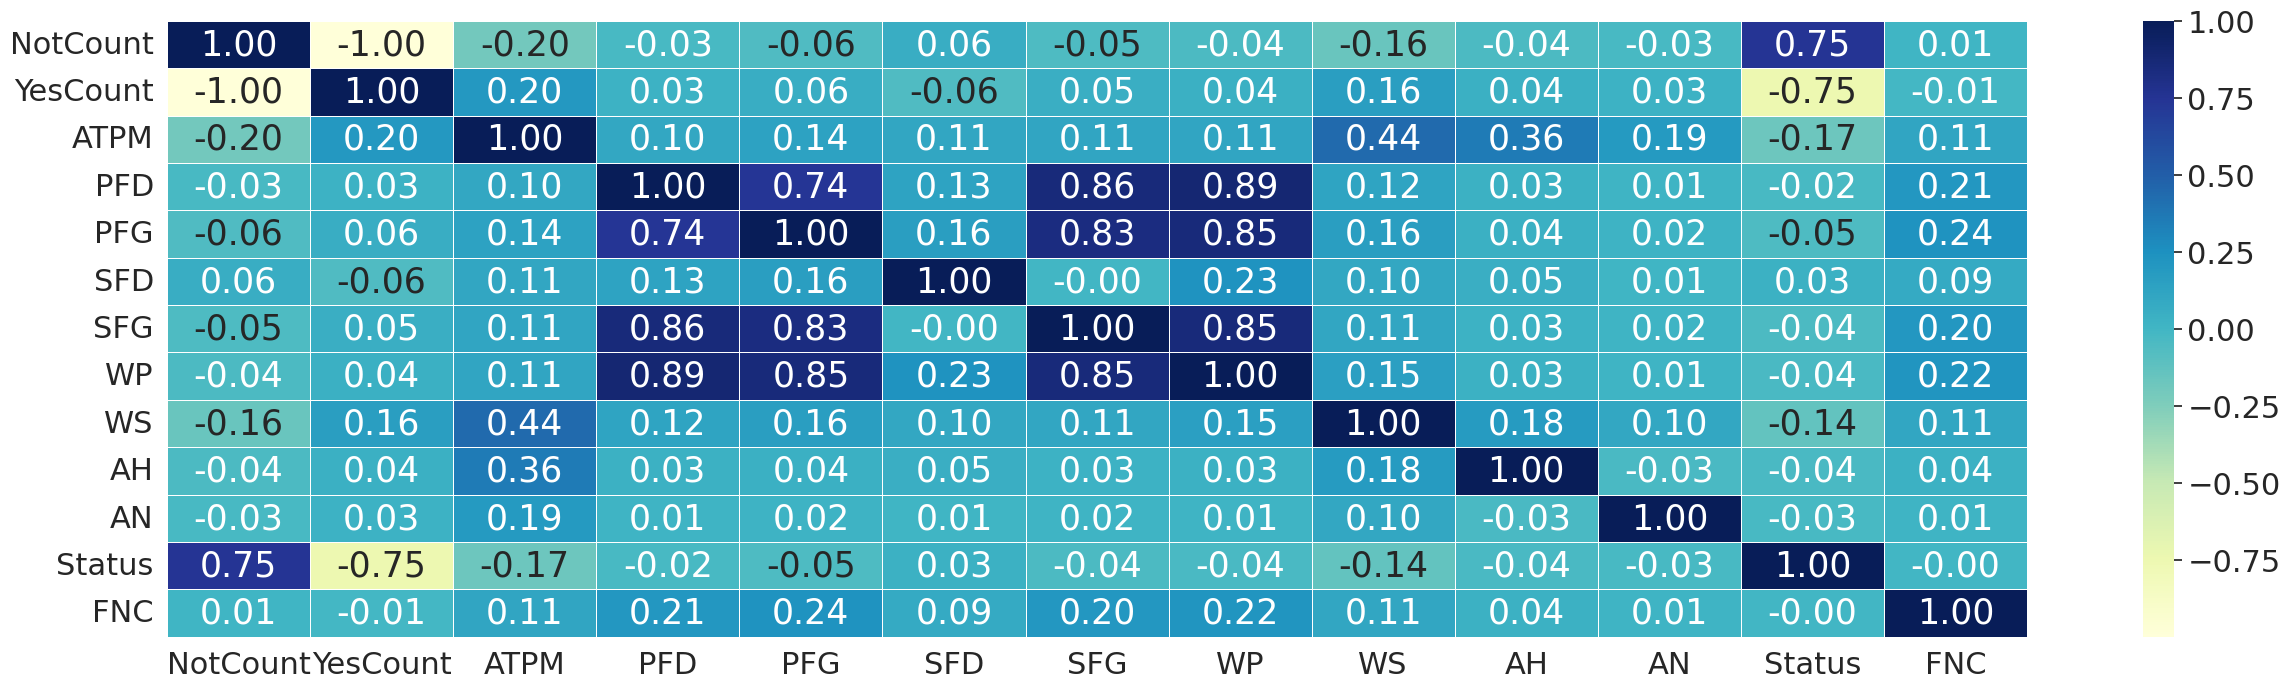

In [ ]:
correlation_train = data.corr("pearson")
sns.set(font_scale=2)
fig = plt.figure(figsize=(30, 8))
ax = sns.heatmap(
    correlation_train,
    annot=True,
    annot_kws={"size": 25},
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
)
fig.show()


1.4 Divide the dataset into Input(x), Output(Y) and the cost weights

In [ ]:
X_1 = data[data.columns[:-2]]
count = X_1["AN"].count()
Y_1 = np.array(data[["Status"]])
X_1['CFN'] = np.array(data["FNC"])
CTP,CFP,CTN,CFN = 4,4,0,t.tensor(data["FNC"])

### 1.4 Split into Train-Test split

In [ ]:
xtrain,xtest,ytrain,ytest=tts(X_1,Y_1,random_state=42,test_size=0.20,shuffle=True)

In [ ]:
X,Y,CFN = np.array(xtrain[xtrain.columns[:-1]]),ytrain,np.array(xtrain["CFN"])

### 1.5 Divide data into mini-batches

In [ ]:
def get_random_array(size):
    random_array = np.random.choice(np.array(range(len(Y)),dtype=np.float64),size,replace=False)
    return np.array(random_array,dtype=np.int32)

##2. Defining Model in Pytorch

In [ ]:
net = t.nn.Sequential( 
    	t.nn.Linear(X_1.columns.shape[0]-1,4),
		t.nn.Sigmoid(),
		t.nn.Linear(4, 1)
    )

torch_ga = torchga.TorchGA(model=net,num_solutions=5)

# 3 Genetic Optimising Algorithm

##3.1 Calculate Fitness Function

In [ ]:
def fitness(ga_model, solution, sol_idx):
    pred = torchga.predict(model=net,solution=solution,data=data_inputs)
    res = 1.0 / loss_function(pred, data_outputs,CFN1).detach().numpy() + 1e-6
    return res

In [ ]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_model.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_model.best_solution()[1]))

In [ ]:
random_array = get_random_array(2048)
data_inputs = t.FloatTensor(X[random_array])
CFN1 = t.FloatTensor(CFN[random_array])
data_outputs = t.LongTensor(Y[random_array])

###3.2 Defining Loss Function

In [ ]:
def loss_function(y1,y,CFN1):
    return t.sum(y*(y1*CTP + (1-y1)*CFN1) + (1-y)*(y1*CFP + (1-y1)*CTN))

###3.3 Training model (with Cost Sensative Logistic Regression)

In [ ]:
ga_model = pygad.GA(num_generations=100,
                       num_parents_mating=3,
                       initial_population=torch_ga.population_weights,
                       fitness_func=fitness)
ga_model.run()

##3.4 Iteration vs Fitness Plot

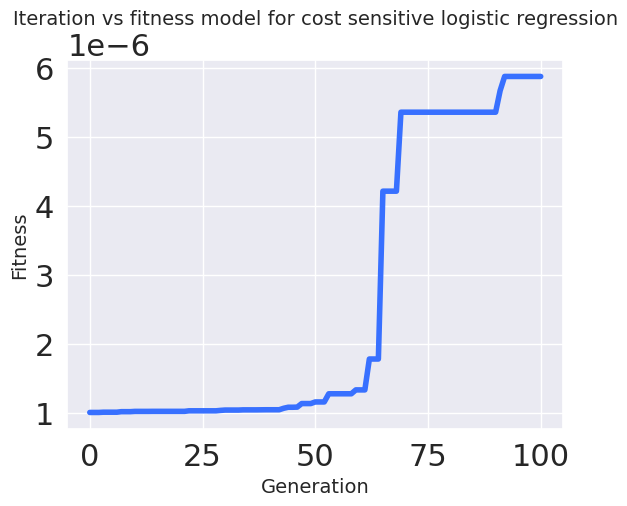

Fitness value for the optimized solution : 5.871893558869525e-06
Index for the optimized solution : 0


In [ ]:
ga_model.plot_fitness(title="Iteration vs fitness model for cost sensitive logistic regression", linewidth=4)
sln, sln_fit, sln_idx = ga_model.best_solution()
print(f"Fitness value for the optimized solution : {sln_fit}")
print(f"Index for the optimized solution : {sln_idx}")

## 3.5 Creating Testing data 

In [ ]:
X2,CFN2 = np.array(xtest[xtest.columns[:-1]]),np.array(xtest["CFN"])
X2 = t.FloatTensor(X2)

In [ ]:
y2 = pygad.torchga.predict(model=net,solution=sln,data=X2)
y2 = (y2-0.5>0).long().squeeze()
ytest = t.LongTensor(ytest)

##3.6 Evaluating loss for testing data

In [ ]:
loss_val = 0
for x,y,cfn,y1 in zip(X2,ytest,CFN2,y2):
    loss_val += y*(y1*CTP + (1-y1)*cfn) + (1-y)*(y1*CFP + (1-y1)*CTN)

In [ ]:
(f'Total Loss for Cost Sensative Logistic Regression: {loss_val.item():0.2f}')

'Total Loss for Cost Sensative Logistic Regression: 95776.91'

In [ ]:
xtrain1 = data_inputs.numpy()
ytrain = data_outputs.numpy()

##3.7 Train Model (with Logistic Regression)

In [ ]:
from sklearn.linear_model import LogisticRegression 

classifier= LogisticRegression().fit(xtrain1, ytrain)  
ypred = classifier.predict(X2.detach().numpy())
y2 = t.tensor(ypred)
y2 = (y2-0.5>0).long().squeeze()
ytest = t.LongTensor(ytest)

loss_val1 = 0
for x,y,cfn,y1 in zip(X2,ytest,CFN2,y2):
    loss_val1 += y*(y1*CTP + (1-y1)*cfn) + (1-y)*(y1*CFP + (1-y1)*CTN)

In [ ]:
(f'Total Loss for Logistic Regression: {loss_val1.item():0.2f}')

'Total Loss for Logistic Regression: 910171.88'

# 4. Evaluated Results

##Savings Cost

In [ ]:
print(f'Savings Cost: {(1-(loss_val/loss_val1)).item(): 0.5f}')

Savings Cost:  0.89477
